# Phần 1: Import thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Phần 2: Khám phá dữ liệu

In [2]:
train_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/train" 


#load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)


class_names = train_ds.class_names
print("Tổng số lớp: ", len(class_names))
for i, name in enumerate(class_names, start=1):
    print(f"{i:02d}. {name}")

Found 70295 files belonging to 38 classes.
Tổng số lớp:  38
01. Apple___Apple_scab
02. Apple___Black_rot
03. Apple___Cedar_apple_rust
04. Apple___healthy
05. Blueberry___healthy
06. Cherry_(including_sour)___Powdery_mildew
07. Cherry_(including_sour)___healthy
08. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
09. Corn_(maize)___Common_rust_
10. Corn_(maize)___Northern_Leaf_Blight
11. Corn_(maize)___healthy
12. Grape___Black_rot
13. Grape___Esca_(Black_Measles)
14. Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15. Grape___healthy
16. Orange___Haunglongbing_(Citrus_greening)
17. Peach___Bacterial_spot
18. Peach___healthy
19. Pepper,_bell___Bacterial_spot
20. Pepper,_bell___healthy
21. Potato___Early_blight
22. Potato___Late_blight
23. Potato___healthy
24. Raspberry___healthy
25. Soybean___healthy
26. Squash___Powdery_mildew
27. Strawberry___Leaf_scorch
28. Strawberry___healthy
29. Tomato___Bacterial_spot
30. Tomato___Early_blight
31. Tomato___Late_blight
32. Tomato___Leaf_Mold
33. Toma

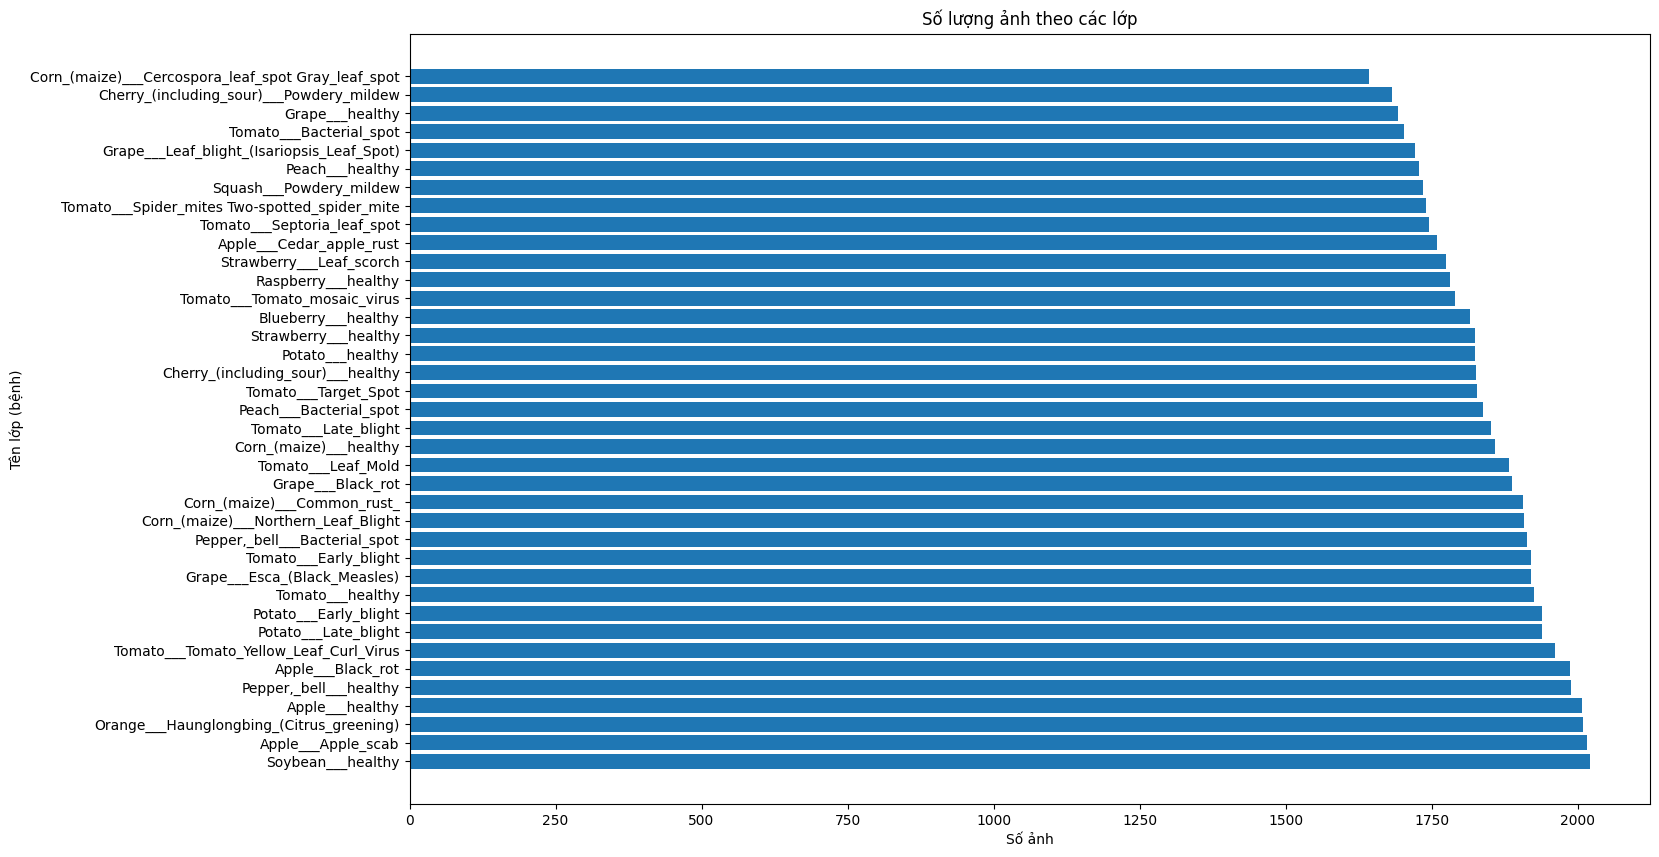

In [5]:
#thống kê ảnh theo từng lớp
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"]).sort_values(by="Count", ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(df_counts["Class"], df_counts["Count"])
plt.xlabel("Số ảnh")
plt.ylabel("Tên lớp (bệnh)")
plt.title("Số lượng ảnh theo các lớp")
plt.show()

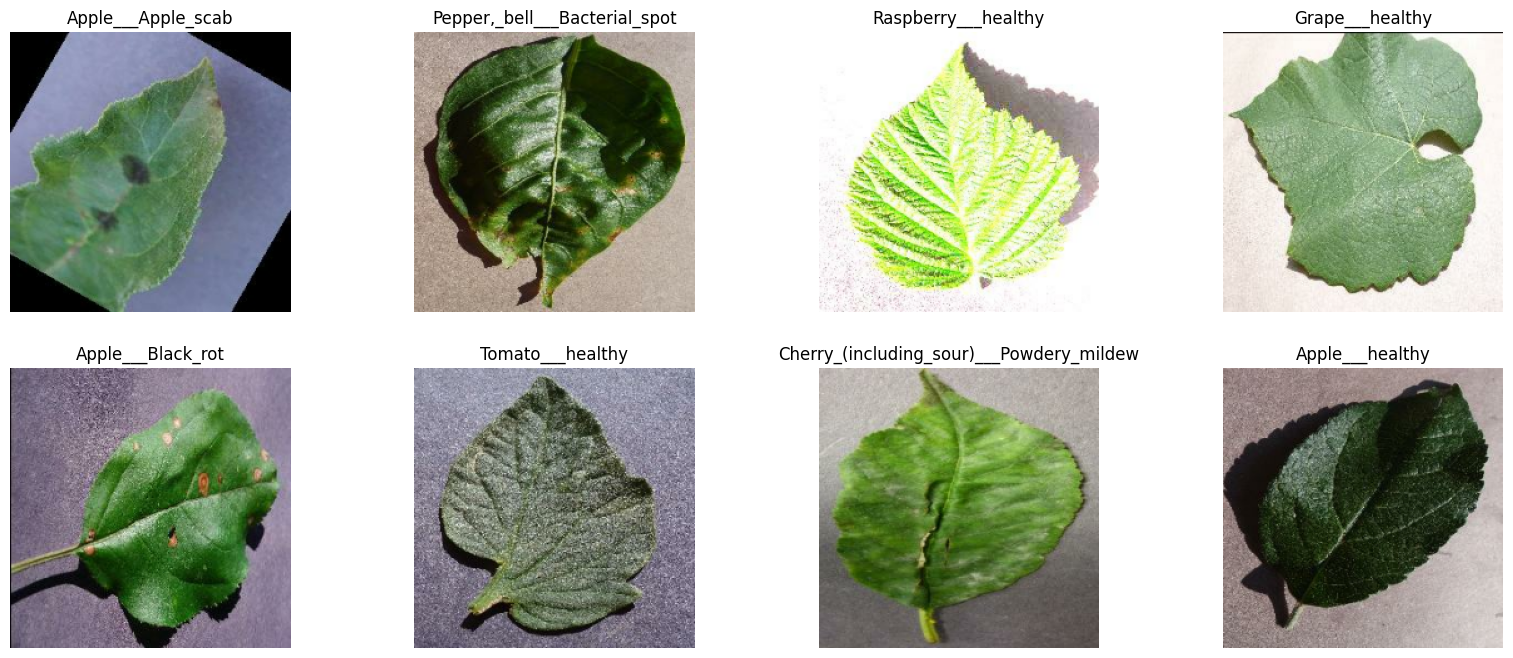

In [6]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(20, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [7]:
sample_path = os.path.join(train_dir, class_names[0])
img_path = os.path.join(sample_path, os.listdir(sample_path)[0])

img = PIL.Image.open(img_path)
print("Kích thước ảnh gốc:", img.size)

Kích thước ảnh gốc: (256, 256)


# Phần 3: Tiền xử lý

# Phần 4: Khai phá dữ liệu

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers

from tensorflow.keras.applications.resnet_v2 import preprocess_input 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
from tensorflow.keras.models import Sequential
from collections import defaultdict

## Mô hình 1: CNN

In [4]:
train_dir = r"D:\Plant_3\processed\train"
valid_dir = r"D:\Plant_3\processed\valid"


BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Chuẩn hóa pixel về [0,1]
    rotation_range=20,         # Xoay nhẹ ±20°
    width_shift_range=0.2,     # Dịch ngang
    height_shift_range=0.2,    # Dịch dọc
    zoom_range=0.2,            # Phóng to/thu nhỏ
    horizontal_flip=True       # Lật ngang
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

val_ds = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_ds.class_indices.keys())
print("Số lớp:", len(class_names))


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Số lớp: 38


In [5]:
num_classes = len(class_names)

model = Sequential([

        layers.Input(shape=(224, 224, 3)),
    
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.MaxPooling2D(2,2),
    

        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),


        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        

        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.4),
        layers.Dense(len(class_names), activation='softmax')
])

In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=6, #6 epoch khong cai thien dung
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,     # giảm LR 1/2 nếu val_loss không giảm
        patience=3,  
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "best_model_CNN.h5",  
        monitor='val_accuracy', 
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    workers = 6,
    use_multiprocessing = False  
)

Epoch 1/50
2197/2197 [==============================] - 334s 147ms/step - loss: 1.9305 - accuracy: 0.4431 - val_loss: 3.2683 - val_accuracy: 0.2969 - lr: 1.0000e-04
Epoch 2/50
2197/2197 [==============================] - 308s 140ms/step - loss: 1.2073 - accuracy: 0.6403 - val_loss: 4.2906 - val_accuracy: 0.2332 - lr: 1.0000e-04
Epoch 3/50
2197/2197 [==============================] - 315s 143ms/step - loss: 0.9173 - accuracy: 0.7239 - val_loss: 3.4359 - val_accuracy: 0.3553 - lr: 1.0000e-04
Epoch 4/50
2197/2197 [==============================] - 309s 140ms/step - loss: 0.7714 - accuracy: 0.7669 - val_loss: 2.3527 - val_accuracy: 0.5043 - lr: 1.0000e-04
Epoch 5/50
2197/2197 [==============================] - 307s 139ms/step - loss: 0.6586 - accuracy: 0.7993 - val_loss: 1.9474 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 6/50
2197/2197 [==============================] - 308s 140ms/step - loss: 0.5803 - accuracy: 0.8216 - val_loss: 2.0564 - val_accuracy: 0.5674 - lr: 1.0000e-04
Epoch 7/50

In [8]:
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_acc = history.history['val_accuracy'][best_epoch - 1]
print(f"Best model at epoch {best_epoch} with val_accuracy = {best_val_acc:.2%}")

Best model at epoch 24 with val_accuracy = 77.11%


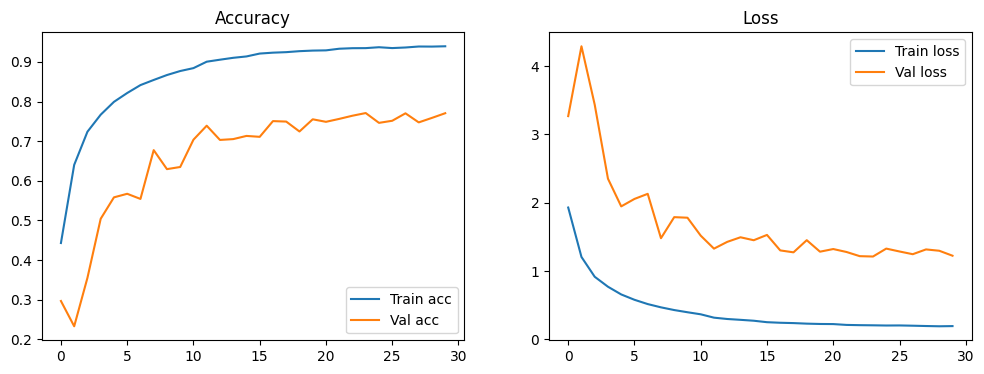

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss")
plt.show()

Found 17572 images belonging to 38 classes.
550/550 ━━━━━━━━━━━━━━━━━━━━ 101s 183ms/step


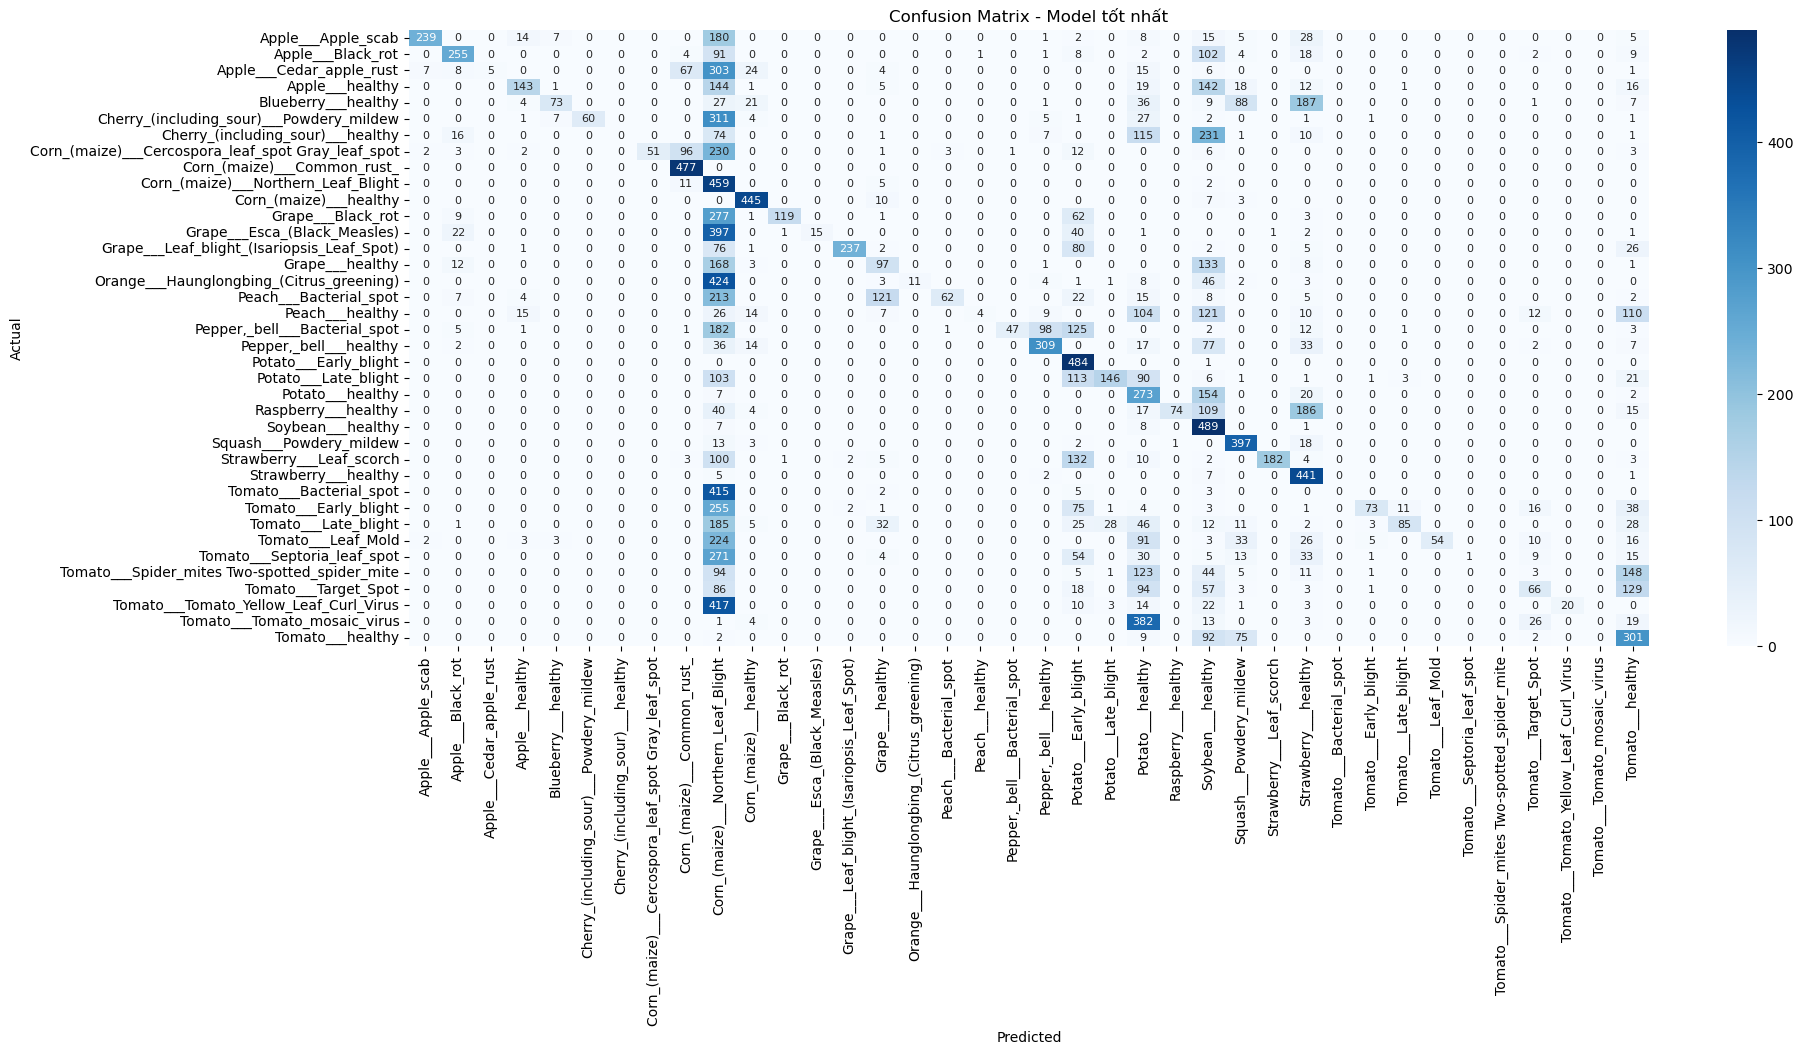


Báo cáo phân loại:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.47      0.63       504
                                 Apple___Black_rot       0.75      0.51      0.61       497
                          Apple___Cedar_apple_rust       1.00      0.01      0.02       440
                                   Apple___healthy       0.76      0.28      0.41       502
                               Blueberry___healthy       0.80      0.16      0.27       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.14      0.25       421
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.12      0.22       410
                       Corn_(maize)___Common_rust_       0.72      1.00      0.84       477
               Corn_(maize)___Northern_Leaf_Blight       0.

In [16]:
model = tf.keras.models.load_model(r"D:\Plan_2\best_model_CNN.h5")

val_dir = "D:/Plant/New Plant Diseases Dataset(Augmented)/valid"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

val_datagen = ImageDataGenerator(rescale=1./255)


val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=False
)


class_names = list(val_generator.class_indices.keys())


y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Model tốt nhất")
plt.show()

#kết quả
print("\nBáo cáo phân loại:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))

## Mô hình 2: ResNet50V2

In [11]:
train_dir = r"D:/Plant/New Plant Diseases Dataset(Augmented)/train"
valid_dir = r"D:/Plant/New Plant Diseases Dataset(Augmented)/valid"


IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Augmentation cho train
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #hàm xử lý của ResNetV2 [-1,1]
    rotation_range=30, #xoay 
    width_shift_range=0.2,      #dịch trái, phải
    height_shift_range=0.2,     #dịch dọc
    horizontal_flip=True,       #lật ảnh
    brightness_range=[0.7, 1.3], # Thêm thay đổi độ sáng
    zoom_range=0.2, 
    fill_mode='constant', cval=0 
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
NUM_CLASSES = len(train_gen.class_indices)
print(f"Tìm thấy {NUM_CLASSES} lớp (thư mục).")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Tìm thấy 38 lớp (thư mục).


In [5]:
plant_groups = defaultdict(int)
for cls in os.listdir(train_dir):
    if "___" in cls:
        plant = cls.split("___")[0]  # ví dụ "Tomato"
        plant_groups[plant] += len([
            f for f in os.listdir(os.path.join(train_dir, cls))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

total_images = sum(plant_groups.values())
plant_weights = {plant: total_images / count for plant, count in plant_groups.items()}

print("\nTrọng số cho từng loại cây (đã tính):")
for k, v in plant_weights.items():
    print(f"{k}: {v:.2f}")

# Lấy ánh xạ Tên Lớp -> Chỉ Số 
class_indices = train_gen.class_indices
# class_indices sẽ là: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, ...}

# Tạo dictionary trọng số cuối cùng (Chỉ Số -> Trọng Số) 
final_class_weights = {}
for class_name, class_index in class_indices.items():
    plant_name_key = class_name.split("___")[0] 
    
    if plant_name_key in plant_weights:
        weight = plant_weights[plant_name_key]
        final_class_weights[class_index] = weight
    else:
        print(f"Không tìm thấy trọng số cho nhóm '{plant_name_key}'")

print("\nTrọng số cuối cùng theo từng lớp:")
print(f"{'Chỉ số':<8} {'Lớp bệnh':<55} {'Loại cây':<30} {'Trọng số':>15}")
print("-" * 90)
for class_name, class_index in sorted(class_indices.items(), key=lambda x: x[1]):
    plant_name_key = class_name.split("___")[0]
    weight = final_class_weights.get(class_index, None)
    print(f"{class_index:<8} {class_name:<55} {plant_name_key:30} {weight:>15.2f}")



Trọng số cho từng loại cây (đã tính):
Apple: 9.05
Blueberry: 38.71
Cherry_(including_sour): 20.03
Corn_(maize): 9.61
Grape: 9.73
Orange: 34.97
Peach: 19.71
Pepper,_bell: 18.02
Potato: 12.33
Raspberry: 39.47
Soybean: 34.77
Squash: 40.49
Strawberry: 19.54
Tomato: 3.83

Trọng số cuối cùng theo từng lớp:
Chỉ số   Lớp bệnh                                                Loại cây                              Trọng số
------------------------------------------------------------------------------------------
0        Apple___Apple_scab                                      Apple                                     9.05
1        Apple___Black_rot                                       Apple                                     9.05
2        Apple___Cedar_apple_rust                                Apple                                     9.05
3        Apple___healthy                                         Apple                                     9.05
4        Blueberry___healthy                  

In [9]:
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

#Đóng băng các lớp của mô hình gốc
base_model.trainable = False


#Xây dựng mô hình
inputs = base_model.input
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x) # Thêm Dropout để giảm overfitting
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [10]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=6, #6 epoch khong cai thien dung
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,     # giảm LR 1/2 nếu val_loss không giảm
        patience=3,  
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath=r"D:\Model_best\best_model_RN50.h5",  
        monitor='val_loss', 
        save_best_only=True
    )
]

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    workers = 6,
    use_multiprocessing = False,
    class_weight=final_class_weights,
    callbacks=callbacks
)

Epoch 1/50
2197/2197 [==============================] - 415s 185ms/step - loss: 7.5666 - accuracy: 0.7680 - val_loss: 0.2871 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 2/50
2197/2197 [==============================] - 441s 200ms/step - loss: 3.8664 - accuracy: 0.8547 - val_loss: 0.2190 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 3/50
2197/2197 [==============================] - 380s 172ms/step - loss: 3.5067 - accuracy: 0.8645 - val_loss: 0.2075 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 4/50
2197/2197 [==============================] - 378s 172ms/step - loss: 3.3519 - accuracy: 0.8727 - val_loss: 0.1888 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 5/50
2197/2197 [==============================] - 379s 172ms/step - loss: 3.3343 - accuracy: 0.8746 - val_loss: 0.1948 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 6/50
2197/2197 [==============================] - 381s 173ms/step - loss: 3.2239 - accuracy: 0.8778 - val_loss: 0.1839 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 7/50
2197/2197 [============

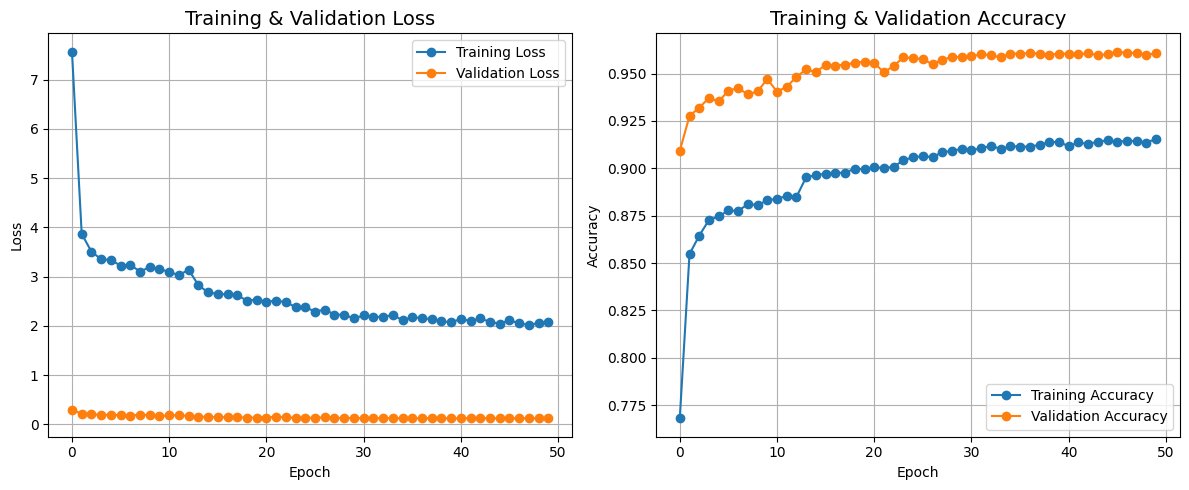

In [12]:
# --- Vẽ biểu đồ ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.models import load_model

# Load model đã fine-tune trước đó
model = load_model(r"D:\Model_best\best_model_RN50.h5")

In [8]:
print("\nTinh chỉnh (Fine-Tuning)")
print("Mở băng các lớp cuối ")

model.trainable = True 

fine_tune_at = 155
# Đóng băng tất cả các lớp TRƯỚC lớp 155
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

    
#Re-compile với Learning Rate nhỏ
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # LR rất nhỏ
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

new_callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, # Giảm LR mạnh hơn
        patience=4, 
        min_lr=1e-7 # LR nhỏ nhất
    ),
    ModelCheckpoint(
        filepath=r"D:\Model_best\best_model_finetuned_RN.h5",
        monitor='val_loss', 
        save_best_only=True
    )
]



Tinh chỉnh (Fine-Tuning)
Mở băng các lớp cuối 
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                            

In [9]:
print("Tiếp tục huấn luyện (fine-tuning) với LR thấp...")
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, 
    workers = 6,
    use_multiprocessing = False,
    class_weight=final_class_weights,
    callbacks=new_callbacks
)

Tiếp tục huấn luyện (fine-tuning) với LR thấp...
Epoch 1/50
2197/2197 [==============================] - 404s 179ms/step - loss: 4.3480 - accuracy: 0.8626 - val_loss: 0.1332 - val_accuracy: 0.9556 - lr: 1.0000e-05
Epoch 2/50
2197/2197 [==============================] - 377s 171ms/step - loss: 1.7920 - accuracy: 0.9165 - val_loss: 0.1057 - val_accuracy: 0.9652 - lr: 1.0000e-05
Epoch 3/50
2197/2197 [==============================] - 377s 171ms/step - loss: 1.3409 - accuracy: 0.9357 - val_loss: 0.0865 - val_accuracy: 0.9704 - lr: 1.0000e-05
Epoch 4/50
2197/2197 [==============================] - 423s 192ms/step - loss: 1.0066 - accuracy: 0.9476 - val_loss: 0.0751 - val_accuracy: 0.9737 - lr: 1.0000e-05
Epoch 5/50
2197/2197 [==============================] - 399s 181ms/step - loss: 0.8467 - accuracy: 0.9556 - val_loss: 0.0633 - val_accuracy: 0.9771 - lr: 1.0000e-05
Epoch 6/50
2197/2197 [==============================] - 378s 172ms/step - loss: 0.6904 - accuracy: 0.9630 - val_loss: 0.0520 -

In [10]:
val_acc = history_finetune.history['val_accuracy']

best_epoch = val_acc.index(max(val_acc)) + 1 

print("Epoch tốt nhất:", best_epoch)
print("Validation Accuracy cao nhất:", max(val_acc))


Epoch tốt nhất: 47
Validation Accuracy cao nhất: 0.9969838261604309


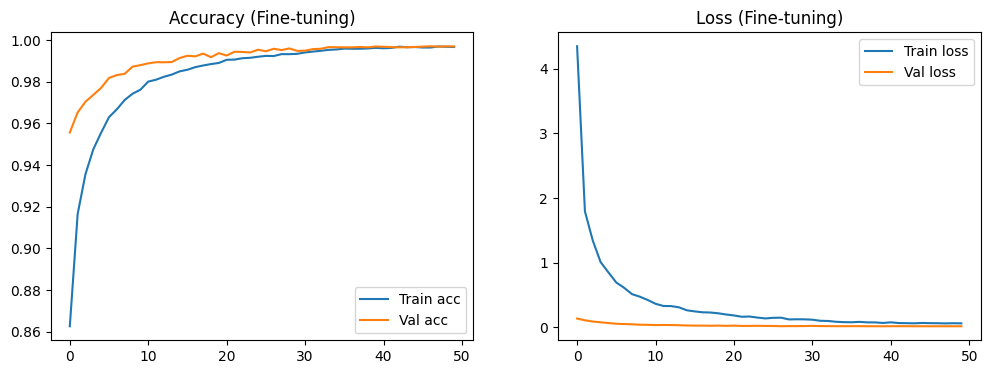

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='Train acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Accuracy (Fine-tuning)")

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='Train loss')
plt.plot(history_finetune.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Loss (Fine-tuning)")
plt.show()


In [14]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
model = load_model(r"D:\Model_best\best_model_finetuned_RN.h5")

Found 17572 images belonging to 38 classes.
550/550 ━━━━━━━━━━━━━━━━━━━━ 460s 834ms/step


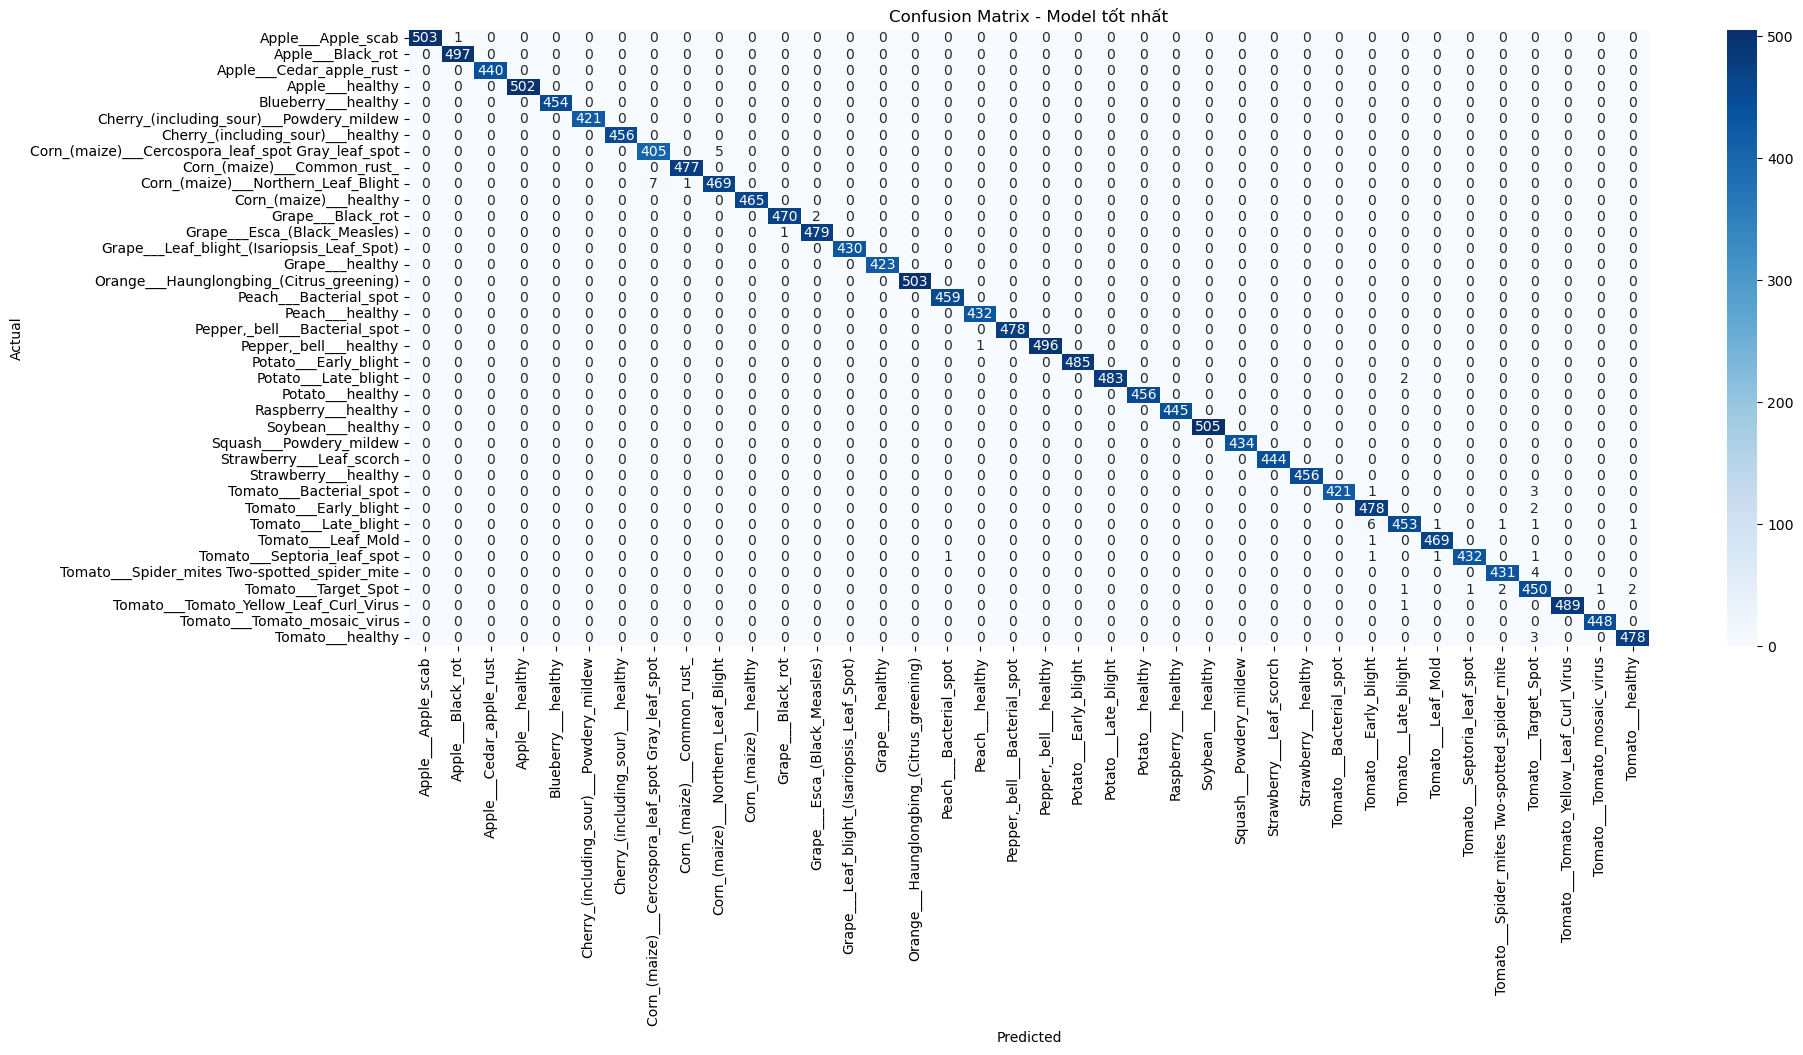


Báo cáo phân loại:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.99      0.99       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.

In [15]:
val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

class_names = list(val_generator.class_indices.keys())

val_generator.reset()  
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(20, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 10})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Model tốt nhất")
plt.show()

print("\nBáo cáo phân loại:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))